# IoT23 Dataset Preprocessing and Model Training
This notebook preprocesses the original IoT23 dataset and creates machine learning models for detecting malicious traffic in IoT devices.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import gc  # Garbage collection for memory management

print("Libraries imported successfully!")


2026-01-02 13:10:38.164237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!


## 2. Load Dataset

In [2]:
# Load C&C Detection Dataset with DNS Features and Balance Classes
print("="*70)
print("LOADING C&C DETECTION DATASET WITH DNS FEATURES")
print("="*70)

print("\nLoading dataset...")
data = pd.read_csv('../iot23_cc_with_dns_features.csv')

print(f"Initial dataset shape: {data.shape}")
print(f"\nRaw label distribution:")
print(data['label'].value_counts())

# Show DNS feature statistics
print(f"\nDNS-Related Features:")
if 'is_dns_port' in data.columns:
    dns_port_count = data['is_dns_port'].sum()
    print(f"  Traffic using DNS port (53): {dns_port_count:,} ({dns_port_count/len(data)*100:.2f}%)")
if 'is_dns_service' in data.columns:
    dns_service_count = data['is_dns_service'].sum()
    print(f"  Traffic with DNS service: {dns_service_count:,} ({dns_service_count/len(data)*100:.2f}%)")
if 'dns_like_pattern' in data.columns:
    dns_pattern_count = data['dns_like_pattern'].sum()
    print(f"  DNS-like patterns: {dns_pattern_count:,} ({dns_pattern_count/len(data)*100:.2f}%)")

print(f"\nOriginal memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ============= BALANCE THE DATASET =============
print("\n" + "="*70)
print("BALANCING DATASET - ADDRESSING CLASS IMBALANCE")
print("="*70)

# Identify C&C and Benign samples
cc_mask = data['label'].astype(str).str.contains('C&C|C%26C', case=False, na=False, regex=True)
benign_mask = data['label'].astype(str).str.contains('Benign|benign', case=False, na=False)

cc_data = data[cc_mask]
benign_data = data[benign_mask]

print(f"\nOriginal distribution:")
print(f"  C&C Attacks: {len(cc_data):,} ({len(cc_data)/len(data)*100:.2f}%)")
print(f"  Benign: {len(benign_data):,} ({len(benign_data)/len(data)*100:.2f}%)")

# Strategy: Undersample benign to create balanced dataset
# Keep ALL C&C attacks and sample benign to match (with some ratio)
cc_count = len(cc_data)

# Option 1: 1:1 ratio (fully balanced)
# benign_sample_count = cc_count

# Option 2: 1:5 ratio (more realistic, still manageable)
# benign_sample_count = cc_count * 5

# Option 3: 1:10 ratio (balanced but with more benign for better training)
benign_sample_count = min(cc_count * 10, len(benign_data))

print(f"\nBalancing strategy: Keep all {cc_count:,} C&C attacks")
print(f"                    Sample {benign_sample_count:,} benign traffic")
print(f"                    Ratio - C&C:Benign = 1:{benign_sample_count//cc_count}")

# Sample benign data
benign_sampled = benign_data.sample(n=benign_sample_count, random_state=42)

# Combine
data_balanced = pd.concat([cc_data, benign_sampled], ignore_index=True)

# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Clean up memory
del data, cc_data, benign_data, benign_sampled
gc.collect()

print(f"\nBalanced dataset shape: {data_balanced.shape}")
print(f"\nBalanced label distribution:")
label_counts = data_balanced['label'].value_counts()
print(label_counts)

# Calculate class distribution
cc_count_final = data_balanced['label'].astype(str).str.contains('C&C', case=False).sum()
benign_count_final = len(data_balanced) - cc_count_final

print(f"\nFinal distribution:")
print(f"  C&C Attacks: {cc_count_final:,} ({cc_count_final/len(data_balanced)*100:.2f}%)")
print(f"  Benign: {benign_count_final:,} ({benign_count_final/len(data_balanced)*100:.2f}%)")

print(f"\nBalanced memory usage: {data_balanced.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Assign back to 'data' variable for rest of notebook
data = data_balanced
del data_balanced
gc.collect()

print("\n✓ Dataset balanced and ready for training!")


LOADING C&C DETECTION DATASET WITH DNS FEATURES

Loading dataset...
Initial dataset shape: (30917198, 24)

Raw label distribution:
label
-   Benign   -                                30284212
Benign                                          508759
COLnd035cNITygYHp3   Benign   -                  46143
-   Malicious   C&C-HeartBeat                    27894
CARhxZ3hLNVO3xYFok   Benign   -                  19583
-   Malicious   C&C                              13753
C&C                                               8237
C&C-HeartBeat                                     5778
-   benign   -                                    1947
-   Malicious   C&C-HeartBeat-Attack               834
-   Malicious   C&C-FileDownload                    49
-   Malicious   C&C-HeartBeat-FileDownload           9
Name: count, dtype: int64

DNS-Related Features:
  Traffic using DNS port (53): 88,589 (0.29%)
  Traffic with DNS service: 23,051 (0.07%)
  DNS-like patterns: 532,192 (1.72%)

Original memory usage: 7280

## 3. Data Preprocessing

In [3]:
# Encode labels specifically for C&C detection
print("\n" + "="*70)
print("ENCODING LABELS FOR C&C DETECTION")
print("="*70)

print("\nOriginal label distribution:")
print(data['label'].value_counts())

# Create binary classification: Benign (0) vs C&C Attack (1)
def encode_cc_label(label):
    label_str = str(label).lower()
    if 'benign' in label_str:
        return 0  # Benign
    elif 'c&c' in label_str or 'c%26c' in label_str or 'command' in label_str:
        return 1  # C&C Attack
    else:
        # Other attacks - treat as C&C for now or filter out
        return 1
        
data['Label'] = data['label'].apply(encode_cc_label)

# Drop the original text label column
data = data.drop('label', axis=1)

# Check for missing values
missing_count = data.isna().sum().sum()
print(f"\nMissing values: {missing_count}")

if missing_count > 0:
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
    print("Missing values filled with median")

# Convert boolean columns to integers
bool_columns = data.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    data[bool_columns] = data[bool_columns].astype(int)
    print(f"Converted {len(bool_columns)} boolean columns to integers")

print(f"\nFinal dataset shape: {data.shape}")
print(f"\nBinary Label distribution:")
label_dist = data['Label'].value_counts()
for label, count in label_dist.items():
    label_name = "Benign" if label == 0 else "C&C Attack"
    print(f"  {label_name} ({label}): {count:,} ({count/len(data)*100:.2f}%)")

# Optimize data types
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype('int32')
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype('float32')

print(f"\nOptimized memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst few rows:")
data.head()



ENCODING LABELS FOR C&C DETECTION

Original label distribution:
label
-   Benign   -                                555206
-   Malicious   C&C-HeartBeat                  27894
-   Malicious   C&C                            13753
Benign                                          9095
C&C                                             8237
C&C-HeartBeat                                   5778
COLnd035cNITygYHp3   Benign   -                  856
-   Malicious   C&C-HeartBeat-Attack             834
CARhxZ3hLNVO3xYFok   Benign   -                  352
-   Malicious   C&C-FileDownload                  49
-   benign   -                                    31
-   Malicious   C&C-HeartBeat-FileDownload         9
Name: count, dtype: int64

Missing values: 0

Final dataset shape: (622094, 24)

Binary Label distribution:
  Benign (0): 565,540 (90.91%)
  C&C Attack (1): 56,554 (9.09%)

Optimized memory usage: 56.95 MB

First few rows:


,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_SF,service_dhcp,service_dns,service_http,service_unknown,Label
0,32751.0,23.0,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,43746.0,8080.0,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,53070.0,6667.0,3.134196,0.0,0.0,0.0,3.0,180.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,1
3,52989.0,23.0,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,41161.0,23.0,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## 4. Train-Test Split and Standardization

In [4]:
print("="*70)
print("SPLITTING DATA INTO TRAIN AND TEST SETS")
print("="*70)

# Separate features and labels
y = data['Label'].values
X = data.drop('Label', axis=1).values

# Clear the original dataframe from memory
del data
gc.collect()

# Split the data (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

train_benign = (y_train == 0).sum()
train_cc = (y_train == 1).sum()
test_benign = (y_test == 0).sum()
test_cc = (y_test == 1).sum()

print(f"\nTraining set distribution:")
print(f"  Benign (0): {train_benign:,} ({train_benign/len(y_train)*100:.2f}%)")
print(f"  C&C Attack (1): {train_cc:,} ({train_cc/len(y_train)*100:.2f}%)")

print(f"\nTest set distribution:")
print(f"  Benign (0): {test_benign:,} ({test_benign/len(y_test)*100:.2f}%)")
print(f"  C&C Attack (1): {test_cc:,} ({test_cc/len(y_test)*100:.2f}%)")

# Clear temporary variables
del X, y
gc.collect()


SPLITTING DATA INTO TRAIN AND TEST SETS
Training set shape: (373256, 23)
Test set shape: (248838, 23)

Training set distribution:
  Benign (0): 339,324 (90.91%)
  C&C Attack (1): 33,932 (9.09%)

Test set distribution:
  Benign (0): 226,216 (90.91%)
  C&C Attack (1): 22,622 (9.09%)


0

In [5]:
# Standardize features
print("\nStandardizing features...")
st = StandardScaler()

# Fit on training data and transform
X_train = st.fit_transform(X_train)
X_test = st.transform(X_test)

print("Standardization complete!")
print(f"Training set mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
print(f"Test set mean: {X_test.mean():.6f}, std: {X_test.std():.6f}")



Standardizing features...
Standardization complete!
Training set mean: -0.000000, std: 1.000000
Test set mean: 0.001260, std: 1.505324


## 5. Logistic Regression Model (TensorFlow)

In [6]:
# Prepare labels for TensorFlow models
print("Preparing labels for TensorFlow...")
y_train_tf = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_tf = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f"TensorFlow labels shape: {y_train_tf.shape}")


Preparing labels for TensorFlow...
TensorFlow labels shape: (373256, 2)


In [7]:
# Custom Logistic Regression with TensorFlow
print("\nBuilding Logistic Regression model...")

n_features = X_train.shape[1]
weights = tf.Variable(tf.random.normal(shape=(n_features, 2), dtype=tf.float64))
biases = tf.Variable(tf.random.normal(shape=(2,), dtype=tf.float64))

def logistic_regression(x):
    lr = tf.add(tf.matmul(x, weights), biases)
    return lr

def cross_entropy(y_true, y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), dtype=tf.int32)
    preds = tf.cast(tf.argmax(y_pred, axis=1), dtype=tf.int32)
    preds = tf.equal(y_true, preds)
    return tf.reduce_mean(tf.cast(preds, dtype=tf.float32))

def grad(x, y):
    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss_val = cross_entropy(y, y_pred)
    return tape.gradient(loss_val, [weights, biases])

# Training with mini-batches
epochs = 1000  # Reduced epochs for 10M dataset
learning_rate = 0.1
batch_size = 1000

print("Training Logistic Regression...")
for epoch in range(epochs):
    # Random mini-batch
    rand_ind = np.random.choice(range(X_train.shape[0]), batch_size)
    outputs = y_train_tf[rand_ind]
    inputs = X_train[rand_ind]
    
    dw, db = grad(inputs, tf.cast(outputs, float))
    
    weights.assign_sub(learning_rate * dw)
    biases.assign_sub(learning_rate * db)
    
    if epoch % 100 == 0:
        # Evaluate on a subset of test data for speed
        test_sample_idx = np.random.choice(range(X_test.shape[0]), 10000)
        acc = accuracy(y_test_tf[test_sample_idx], 
                      logistic_regression(X_test[test_sample_idx]).numpy())
        print(f"Epoch {epoch}: Accuracy = {acc:.4f}")

print("\nLogistic Regression training complete!")

# Final evaluation
y_pred_lr = tf.argmax(logistic_regression(X_test), axis=1).numpy()
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nFinal Logistic Regression Accuracy: {acc_lr:.6f}")



Building Logistic Regression model...
Training Logistic Regression...
Epoch 0: Accuracy = 0.9104


W0000 00:00:1767355907.715168  180921 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 100: Accuracy = 0.9432
Epoch 200: Accuracy = 0.9490
Epoch 300: Accuracy = 0.9475
Epoch 400: Accuracy = 0.9492
Epoch 500: Accuracy = 0.9483
Epoch 600: Accuracy = 0.9494
Epoch 700: Accuracy = 0.9508
Epoch 800: Accuracy = 0.9492
Epoch 900: Accuracy = 0.9495

Logistic Regression training complete!

Final Logistic Regression Accuracy: 0.949594


## 6. Artificial Neural Network (ANN) Model

In [8]:
# Build ANN model
print("\nBuilding ANN model...")
model = Sequential()
n_features = X_train.shape[1]

model.add(Dense(128, input_shape=(n_features,), activation='relu'))  # Reduced from n_features
model.add(Dense(64, activation='relu'))  # Hidden Layer
model.add(Dense(32, activation='relu'))  # Additional Hidden Layer
model.add(Dense(2, activation='softmax'))  # Output Layer

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("ANN Model Architecture:")
model.summary()



Building ANN model...
ANN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,474 (52.63 KB)

 Trainable params: 13,474 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train ANN with validation
print("\nTraining ANN...")
history = model.fit(
    X_train, y_train_tf, 
    batch_size=5000,  # Larger batch size for 10M rows
    epochs=10,  # Increased epochs
    validation_split=0.1,  # Use 10% of training for validation
    verbose=1
)

print("\nANN training complete!")



Training ANN...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9477 - loss: 0.2746 - val_accuracy: 0.9508 - val_loss: 0.1690
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9504 - loss: 0.1630 - val_accuracy: 0.9509 - val_loss: 0.1568
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9539 - loss: 0.1487 - val_accuracy: 0.9591 - val_loss: 0.1394
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9597 - loss: 0.1298 - val_accuracy: 0.9608 - val_loss: 0.1213
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9621 - loss: 0.1133 - val_accuracy: 0.9668 - val_loss: 0.1061
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9722 - loss: 0.0945 - val_accuracy: 0.9751 - val_loss: 0.0879
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9776 - loss: 0.0804 - val_accuracy: 0.9782 - val_loss: 0.0850
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9796 - loss: 0.0743 - val_accuracy: 

In [10]:
# Evaluate ANN
print("\nEvaluating ANN...")
y_pred = model.predict(X_test, batch_size=10000)
y_test_class = np.argmax(y_test_tf, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_test_class, y_pred_class)
print(f"\nANN Accuracy: {acc:.6f}")
print(f"\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

# Clear predictions from memory
del y_pred
gc.collect()



Evaluating ANN...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

ANN Accuracy: 0.980116

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    226216
           1       0.99      0.79      0.88     22622

    accuracy                           0.98    248838
   macro avg       0.98      0.89      0.93    248838
weighted avg       0.98      0.98      0.98    248838


Confusion Matrix:
[[226022    194]
 [  4754  17868]]


1045

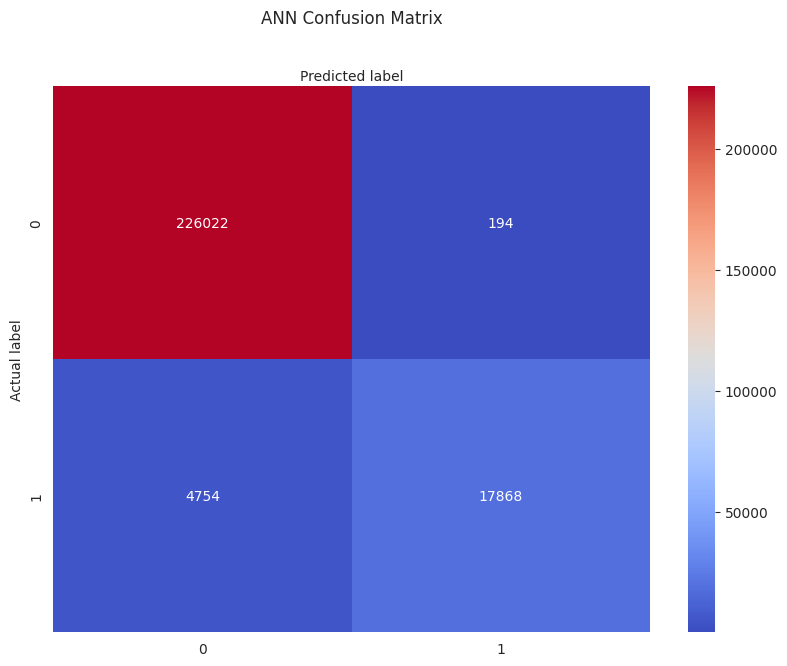

In [11]:
# Plot confusion matrix for ANN
cnf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_names = ['Benign', 'Attack']
fig, ax = plt.subplots(figsize=(8, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('ANN Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


## 7. Decision Tree Classifier

In [12]:
# Train Decision Tree with constraints
print("\nTraining Decision Tree...")
dtree = DecisionTreeClassifier(
    max_depth=20,  # Limit depth to prevent overfitting
    min_samples_split=100,  # Minimum samples to split
    min_samples_leaf=50,  # Minimum samples in leaf
    random_state=42
)

import time
start_time = time.time()
dtree.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Decision Tree training complete in {train_time:.2f} seconds!")



Training Decision Tree...
Decision Tree training complete in 0.41 seconds!


In [13]:
# Evaluate Decision Tree
print("\nEvaluating Decision Tree...")
y_preds_DT = dtree.predict(X_test)

acc = accuracy_score(y_test, y_preds_DT)
print(f"\nDecision Tree Accuracy: {acc:.10f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_preds_DT, target_names=['Benign', 'Attack']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_preds_DT))
print(f"\nPrecision: {precision_score(y_test, y_preds_DT, average='macro'):.5f}")
print(f"Recall: {recall_score(y_test, y_preds_DT, average='macro'):.5f}")
print(f"F1-score: {f1_score(y_test, y_preds_DT, average='macro'):.5f}")



Evaluating Decision Tree...

Decision Tree Accuracy: 0.9994896278

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    226216
      Attack       1.00      1.00      1.00     22622

    accuracy                           1.00    248838
   macro avg       1.00      1.00      1.00    248838
weighted avg       1.00      1.00      1.00    248838


Confusion Matrix:
[[226120     96]
 [    31  22591]]

Precision: 0.99782
Recall: 0.99910
F1-score: 0.99846


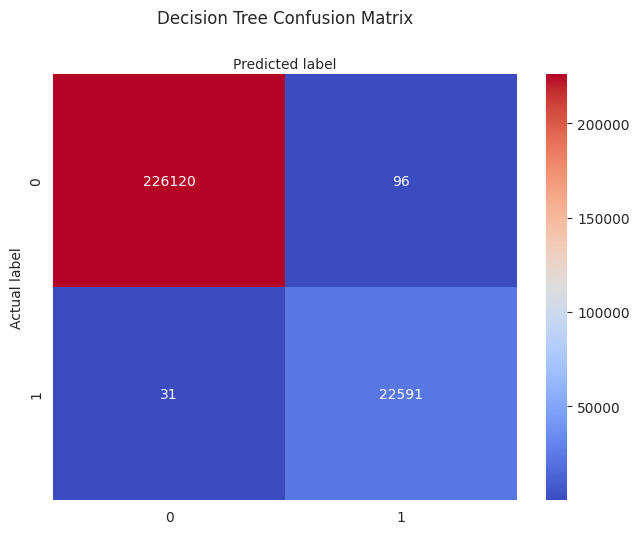

In [14]:
# Plot confusion matrix for Decision Tree
cnf_matrix = confusion_matrix(y_test, y_preds_DT)
class_names = ['0', '1']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Decision Tree Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 8. Random Forest Classifier

In [15]:
# Train Random Forest with optimizations
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=20,  # Limit depth
    min_samples_split=100,
    min_samples_leaf=50,
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1
)

start_time = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"\nRandom Forest training complete in {train_time:.2f} seconds!")



Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s



Random Forest training complete in 6.26 seconds!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


In [16]:
# Evaluate Random Forest
print("\nEvaluating Random Forest...")
y_preds_RF = rf.predict(X_test)

acc = accuracy_score(y_test, y_preds_RF)
print(f"\nRandom Forest Accuracy: {acc:.10f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_preds_RF, target_names=['Benign', 'Attack']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_preds_RF))
print(f"\nPrecision: {precision_score(y_test, y_preds_RF, average='macro'):.5f}")
print(f"Recall: {recall_score(y_test, y_preds_RF, average='macro'):.5f}")
print(f"F1-score: {f1_score(y_test, y_preds_RF, average='macro'):.5f}")


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s



Evaluating Random Forest...

Random Forest Accuracy: 0.9992083203

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    226216
      Attack       0.99      1.00      1.00     22622

    accuracy                           1.00    248838
   macro avg       1.00      1.00      1.00    248838
weighted avg       1.00      1.00      1.00    248838


Confusion Matrix:
[[226024    192]
 [     5  22617]]

Precision: 0.99578
Recall: 0.99947
F1-score: 0.99761


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


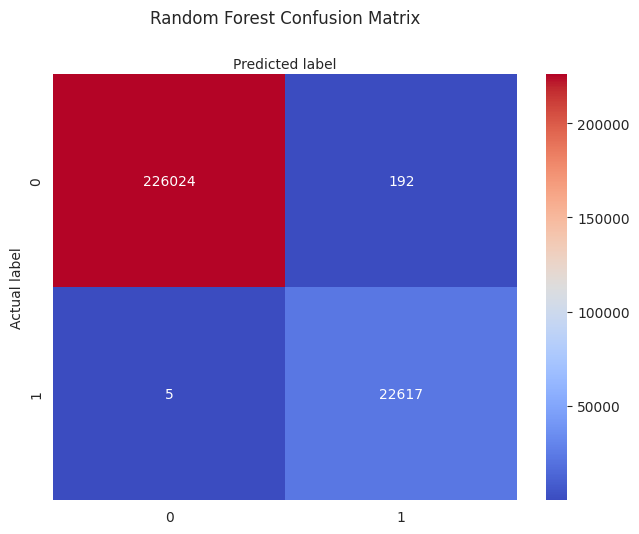

In [17]:
# Plot confusion matrix for Random Forest
cnf_matrix = confusion_matrix(y_test, y_preds_RF)
class_names = ['0', '1']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Random Forest Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 9. XGBoost Classifier

In [18]:
# Train XGBoost with optimizations for large datasets
print("\nTraining XGBoost...")
xgb = XGBClassifier(
    random_state=42,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=10,
    tree_method='hist',  # Faster for large datasets
    subsample=0.8,  # Use 80% of data per tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
xgb.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"\nXGBoost training complete in {train_time:.2f} seconds!")



Training XGBoost...

XGBoost training complete in 3.88 seconds!


In [19]:
# Evaluate XGBoost
print("\nEvaluating XGBoost...")
y_preds_XGB = xgb.predict(X_test)

acc = accuracy_score(y_test, y_preds_XGB)
print(f"\nXGBoost Accuracy: {acc:.10f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_preds_XGB, target_names=['Benign', 'Attack']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_preds_XGB))
print(f"\nPrecision: {precision_score(y_test, y_preds_XGB, average='macro'):.5f}")
print(f"Recall: {recall_score(y_test, y_preds_XGB, average='macro'):.5f}")
print(f"F1-score: {f1_score(y_test, y_preds_XGB, average='macro'):.5f}")



Evaluating XGBoost...

XGBoost Accuracy: 0.9998794396

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    226216
      Attack       1.00      1.00      1.00     22622

    accuracy                           1.00    248838
   macro avg       1.00      1.00      1.00    248838
weighted avg       1.00      1.00      1.00    248838


Confusion Matrix:
[[226197     19]
 [    11  22611]]

Precision: 0.99956
Recall: 0.99971
F1-score: 0.99964


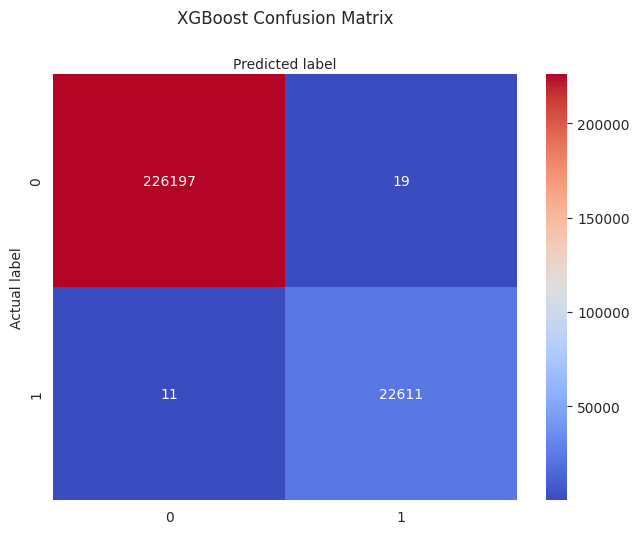

In [20]:
# Plot confusion matrix for XGBoost
cnf_matrix = confusion_matrix(y_test, y_preds_XGB)
class_names = ['0', '1']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('XGBoost Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 10. Model comparison

In [21]:
print("\n" + "="*70)
print("ENHANCED EVALUATION - DNS-BASED C&C DETECTION")
print("="*70)

models_dict = {
    'Logistic Regression': (acc_lr, y_pred_lr),
    'ANN': (accuracy_score(y_test, y_pred_class), y_pred_class),
    'Decision Tree': (accuracy_score(y_test, y_preds_DT), y_preds_DT),
    'Random Forest': (accuracy_score(y_test, y_preds_RF), y_preds_RF),
    'XGBoost': (accuracy_score(y_test, y_preds_XGB), y_preds_XGB)
}

print("\nDetailed Metrics for Each Model:\n")
print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 73)

for model_name, (acc, preds) in models_dict.items():
    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    
    print(f"{model_name:<25} {acc:<12.6f} {precision:<12.6f} {recall:<12.6f} {f1:<12.6f}")

print("\n" + "="*70)
print("CONTEXT: DNS-Based Command & Control Detection for IoT Botnets")
print("This model specifically detects C&C communication over DNS protocol")
print("="*70)


ENHANCED EVALUATION - DNS-BASED C&C DETECTION

Detailed Metrics for Each Model:

Model                     Accuracy     Precision    Recall       F1-Score    
-------------------------------------------------------------------------
Logistic Regression       0.949594     0.950147     0.949594     0.941451    
ANN                       0.980116     0.980296     0.980116     0.979100    
Decision Tree             0.999490     0.999491     0.999490     0.999490    
Random Forest             0.999208     0.999215     0.999208     0.999210    
XGBoost                   0.999879     0.999879     0.999879     0.999879    

CONTEXT: DNS-Based Command & Control Detection for IoT Botnets
This model specifically detects C&C communication over DNS protocol
